# Домашняя работа Шмелёва Юрий

In [202]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm
import numba
from importlib import reload

from IPython.display import HTML, display
import tabulate
from concurrent import futures

# Часть первая, с блекджеком и стратегиями
## 1. Простая стратегия

Напишем стратегию, описанную в задание

In [2]:
HIT = 1
STAND = 0

def make_simple_move(obs):
    player_sum = obs[0]
    
    if player_sum >=  19:
        return STAND
    else:
        return HIT
    
def play_game(env, make_move, num_of_itterations=10):
    rewards = []
    
    for _ in tqdm(range(num_of_itterations)):
        obs = env.reset()
        obs, reward, done, _ = env.step(make_move(obs))
        while not done:
            obs, reward, done, _ = env.step(make_move(obs))
            
        rewards.append(reward)
    
    return rewards

Сыграем 100к игр и оценим нашу стратегию

In [4]:
env = gym.make('Blackjack-v0', natural=True)
rewards = play_game(env, make_simple_move, num_of_itterations=100000)
env.close()

In [5]:
rewards = np.asarray(rewards)
print(f"Средний выигрышь: {rewards.mean()}")

Средний выигрышь: -0.177525


Распределение выигрышей

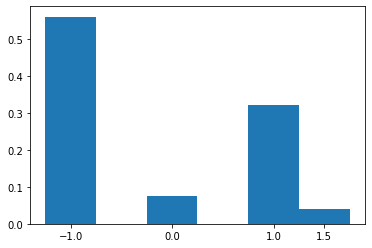

In [6]:
labels, counts = np.unique(rewards, return_counts=True)
counts = counts / len(rewards)
plt.bar(labels, counts, align='center', width=0.5)
plt.gca().set_xticks(labels)
plt.show()

In [7]:
table = [
    ["Награда", "Вероятность получить"],
    ["-1", counts[0]],
    ["0", counts[1]],
    ["1", counts[2]],
    ["1.5", counts[3]]
]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Награда,Вероятность получить
-1,0.56076
0,0.07663
1,0.32136
1.5,0.04125


## 2. Обучение с подкреплением без модели

Реализуем Q-обучение

In [204]:
env = gym.make('Blackjack-v0', natural=True)
player_hands, dealer_hands, aces = env.observation_space[0].n, env.observation_space[1].n, env.observation_space[2].n

nS = player_hands * dealer_hands * aces * 2
nA = 2
final_states = [range(22, player_hands)]

def get_random_Q():
    Q = np.random.random(size=(player_hands, dealer_hands, aces, 2, nA))
    Q[final_states] = 0.0
    Q[..., 0,:] = 0
    return Q

def correct(obs):
    return obs[0], obs[1], 1 if obs[2] else 0

def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    obs = correct(env.reset())
    s = obs + (1,)
    a = pi[s] if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(1000):
        obs, reward, done, info = env.step(a)
        obs = correct(obs)
        s_prime = obs + (a,)
        a_prime = pi[s_prime] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max(Q[s_prime]) - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            break
    
    return Q
            
def compute_policy_by_Q(Q):
    return np.argmax(Q, axis=-1)

def conduct_experiments_pi(env, pi, num_experiments=1000):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        obs = correct(env.reset())
        s = obs + (1,)
        num_steps.append(0)
        total_reward.append(0)
        for _ in range(1000):
            obs, reward, done, info = env.step(pi[s])
            obs = correct(obs)
            s = obs + (pi[s],)
            total_reward[-1] += reward
            num_steps[-1] += 1
            if done:
                break
    return np.mean(total_reward), np.mean(num_steps)

def plot_results(results_Qlearn, verbose_rate):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    ax1.grid()
    ax2.grid()

    avg_returns_Q = np.mean( np.array([ [x[0] for x in res] for res in results_Qlearn]), axis=1)
    avg_steps_Q = np.mean( np.array([ [x[1] for x in res] for res in results_Qlearn]), axis=1)

    ax2.plot(np.arange(1, total_episodes+1, verbose_rate), avg_steps_Q, label="Среднее число шагов в Q-обучении", color="C3")
    ax1.plot(np.arange(1, total_episodes+1, verbose_rate), avg_returns_Q, label="Средний результат стратегии в Q-обучении", color="C2")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper left")
    plt.show()

Получим результаты при gamma = 1

In [48]:
env = gym.make('Blackjack-v0', natural=True)
num_experiments, num_experiments_pi = 10, 100000
verbose_rate = 15000

total_episodes = 150000
gamma = 1

results_Qlearn = []


Q_arr = [ get_random_Q() for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]

for n in tqdm(range(1, total_episodes+1)):
    [Q_learning_episode(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments)]
    pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]
    if n % verbose_rate == 0:
        result = [ conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


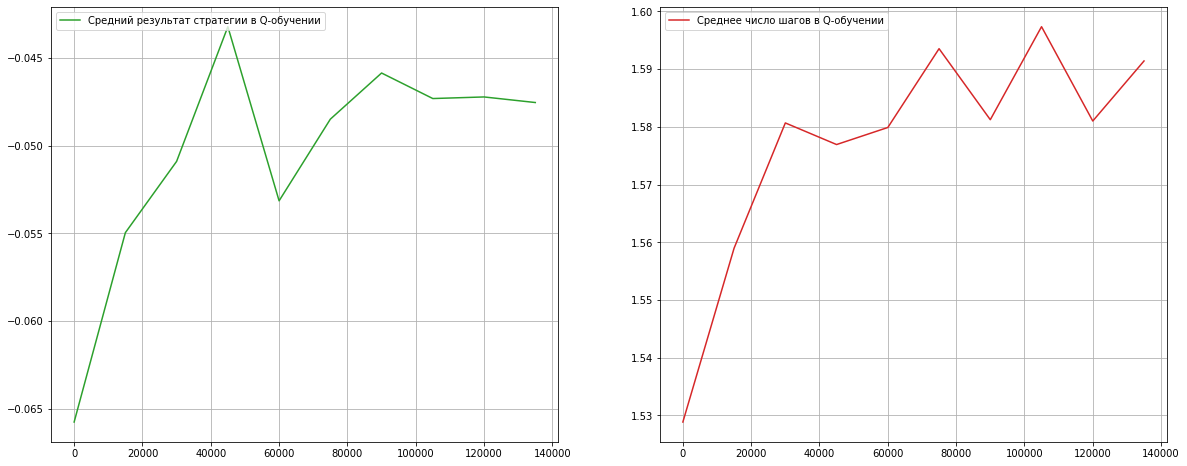

In [49]:
plot_results(results_Qlearn, verbose_rate)

In [50]:
result = np.asarray(result)
rewards, steps = result[:,0], result[:,1]
print(f'Средняя награда: {rewards.mean()}')
print(f'Среднее число шагов: {steps.mean()}')

Средняя награда: -0.0475305
Среднее число шагов: 1.591417


Получим результаты при gamma = 0.99

In [205]:
env = gym.make('Blackjack-v0', natural=True)
num_experiments, num_experiments_pi = 10, 100000
verbose_rate = 15000

total_episodes = 150000
gamma = 0.99

results_Qlearn = []


Q_arr = [ get_random_Q() for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]

for n in tqdm(range(1, total_episodes+1)):
    [Q_learning_episode(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments)]
    pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]
    if n % verbose_rate == 0:
        result = [ conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


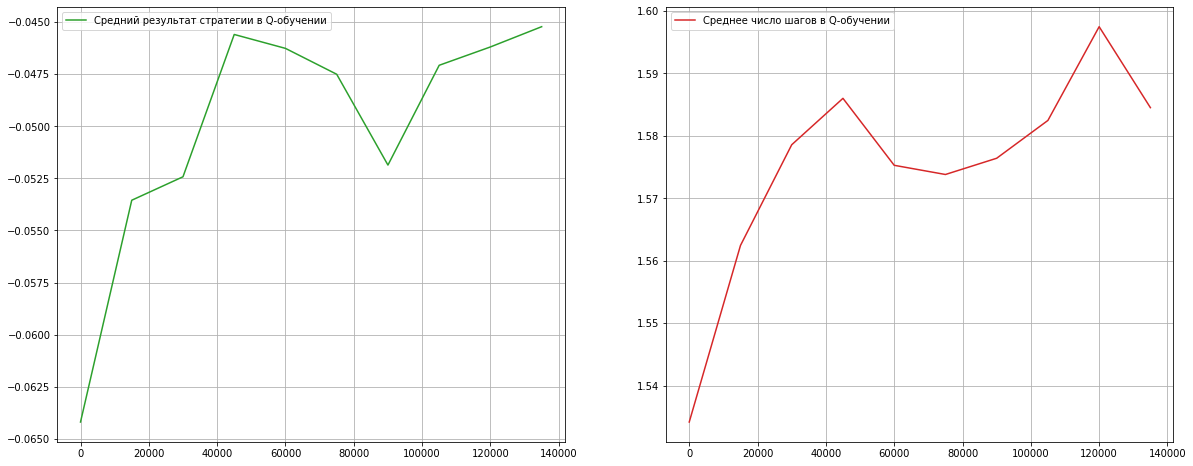

In [46]:
plot_results(results_Qlearn, verbose_rate)

In [47]:
result = np.asarray([ conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ])
rewards, steps = result[:,0], result[:,1]
print(f'Средняя награда: {rewards.mean()}')
print(f'Среднее число шагов: {steps.mean()}')

Средняя награда: -0.045218999999999995
Среднее число шагов: 1.584514


Рассмотрим результаты при gamma = 0.9

In [51]:
env = gym.make('Blackjack-v0', natural=True)
num_experiments, num_experiments_pi = 10, 100000
verbose_rate = 15000

total_episodes = 150000
gamma = 0.9

results_Qlearn = []


Q_arr = [ get_random_Q() for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]

for n in tqdm(range(1, total_episodes+1)):
    [Q_learning_episode(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments)]
    pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]
    if n % verbose_rate == 0:
        result = [ conduct_experiments_pi(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


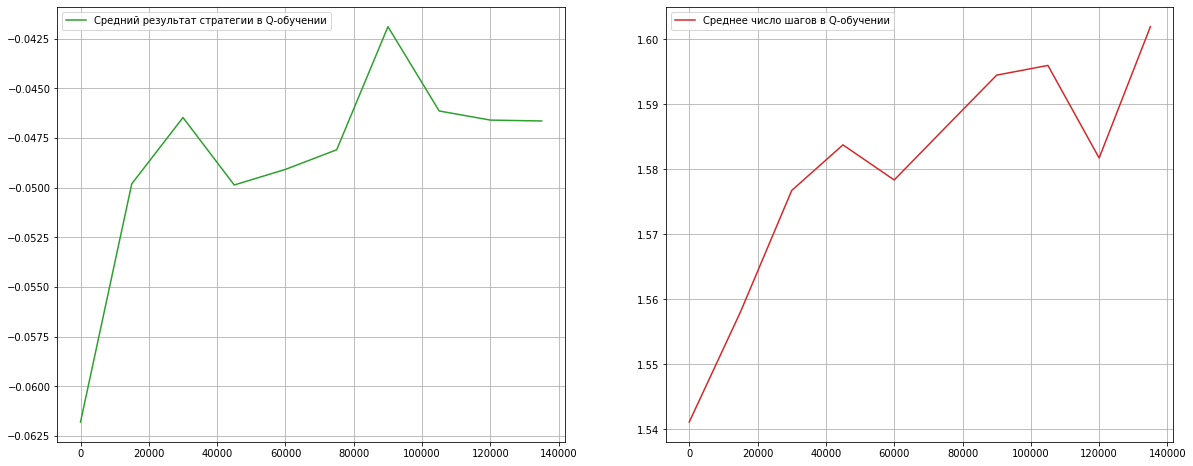

In [52]:
plot_results(results_Qlearn, verbose_rate)

In [53]:
result = np.asarray(result)
rewards, steps = result[:,0], result[:,1]
print(f'Средняя награда: {rewards.mean()}')
print(f'Среднее число шагов: {steps.mean()}')

Средняя награда: -0.0466375
Среднее число шагов: 1.601949


При gamma = 0.99 был получен наилучший выйгрышь равный -0.0466

# Часть вторая, удвоенная

Напишем функции обучение с учётом возможности удваивать ставку

In [165]:
nS = player_hands * dealer_hands * aces * 2
nA = 3
final_states = [range(22, player_hands)]

def get_random_Q():
    Q = np.random.random(size=(player_hands, dealer_hands, aces, 2, nA))
    Q[final_states] = 0.0
    Q[..., 0,:] = 0
    return Q

def Q_learning_episode_with_double(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    obs = correct(env.reset())
    s = obs + (1,)
    a = pi[s] if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(1000):
        if a == 2:
            obs, reward, done, info = env.step(1)
            if not done:
                obs, reward, done, info = env.step(0)
            reward *= 2
        else:
            obs, reward, done, info = env.step(a)
            
        obs = correct(obs)
        s_prime = obs + (a % 2,)
        a_prime = pi[s_prime] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max(Q[s_prime]) - Q[s][a])
        s, a = s_prime, a_prime

        if done:
            break

    return Q
            
def conduct_experiments_pi_with_double(env, pi, num_experiments=1000):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        obs = correct(env.reset())
        s = obs + (1,)
        num_steps.append(0)
        total_reward.append(0)
        for _ in range(1000):
            if pi[s] == 2:
                obs, reward, done, info = env.step(1)
                if not done:
                    obs, reward, done, info = env.step(0)
                reward *= 2
            else:
                obs, reward, done, info = env.step(pi[s])
                
            obs = correct(obs)
            s = obs + (pi[s] % 2,)
            total_reward[-1] += reward
            num_steps[-1] += 1
            if done:
                break
    return np.mean(total_reward), np.mean(num_steps)

Рассмотрим графики при разных gamma

Рассмотрим при gamma = 1

In [200]:
env = gym.make('Blackjack-v0', natural=True)
num_experiments, num_experiments_pi = 10, 100000
verbose_rate = 15000

total_episodes = 150000
gamma = 1

results_Qlearn = []


Q_arr = [ get_random_Q() for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]

for n in tqdm(range(1, total_episodes+1)):
    [Q_learning_episode_with_double(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments)]
    pi_arr =  [ compute_policy_by_Q(Q) for Q in Q_arr ]
    if n % verbose_rate == 0:
        result = [ conduct_experiments_pi_with_double(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


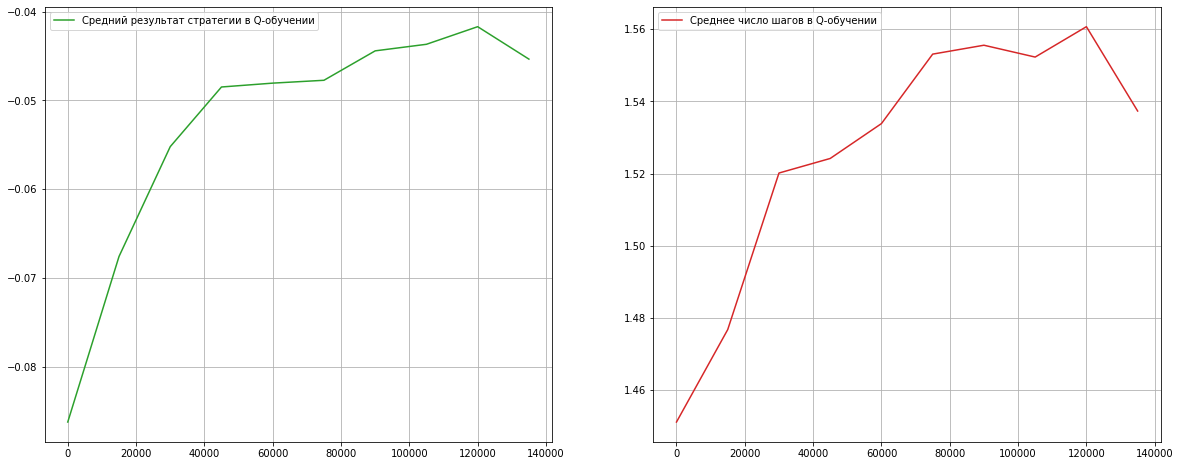

In [201]:
plot_results(results_Qlearn, verbose_rate)

In [202]:
result = np.asarray(result)
rewards, steps = result[:,0], result[:,1]
print(f'Средняя награда: {rewards.mean()}')
print(f'Среднее число шагов: {steps.mean()}')

Средняя награда: -0.045351999999999996
Среднее число шагов: 1.5373180000000002


Попробуем gamma = 0.99

In [194]:
env = gym.make('Blackjack-v0', natural=True)
total_episodes = 150000
gamma = 0.99

Q_hist_Qlearn = [ ]

Q = get_random_Q()
pi = compute_policy_by_Q(Q)

for n in tqdm(range(total_episodes)):
    Q_learning_episode_with_double(env, pi, Q, alpha=0.05, epsilon= 0.1, gamma=gamma)
    pi = compute_policy_by_Q(Q)
    Q_hist_Qlearn.append(np.copy(Q))

env.close()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


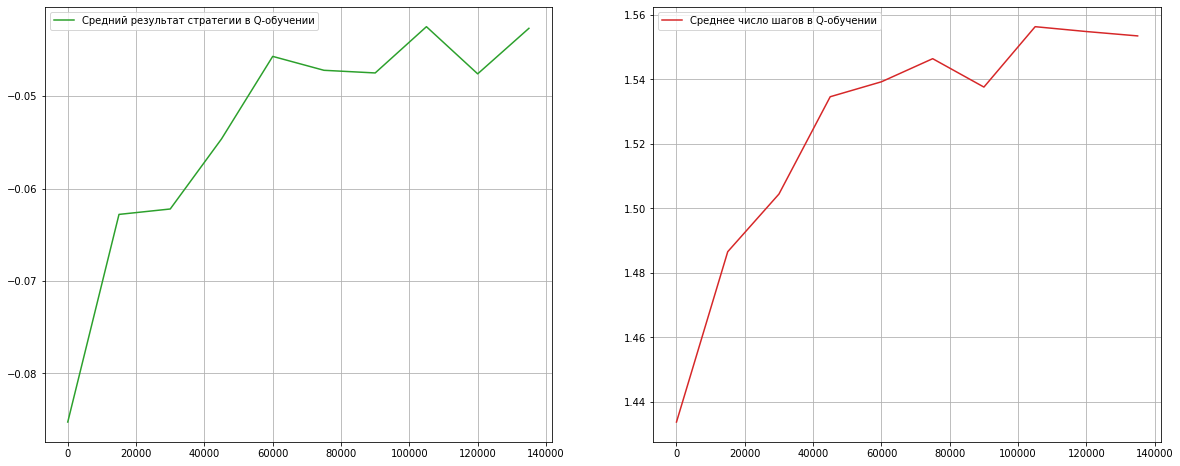

In [198]:
plot_results(results_Qlearn, verbose_rate)

In [199]:
result = np.asarray(result)
rewards, steps = result[:,0], result[:,1]
print(f'Средняя награда: {rewards.mean()}')
print(f'Среднее число шагов: {steps.mean()}')

Средняя награда: -0.042655
Среднее число шагов: 1.5535119999999998


Попробуем при gamma = 0.9

In [203]:
env = gym.make('Blackjack-v0', natural=True)
num_experiments, num_experiments_pi = 10, 100000
verbose_rate = 15000

total_episodes = 150000
gamma = 0.9

results_Qlearn = []


Q_arr = [ get_random_Q() for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]

for n in tqdm(range(1, total_episodes+1)):
    [Q_learning_episode_with_double(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments)]
    pi_arr =  [ compute_policy_by_Q(Q) for Q in Q_arr ]
    if n % verbose_rate == 0:
        result = [ conduct_experiments_pi_with_double(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


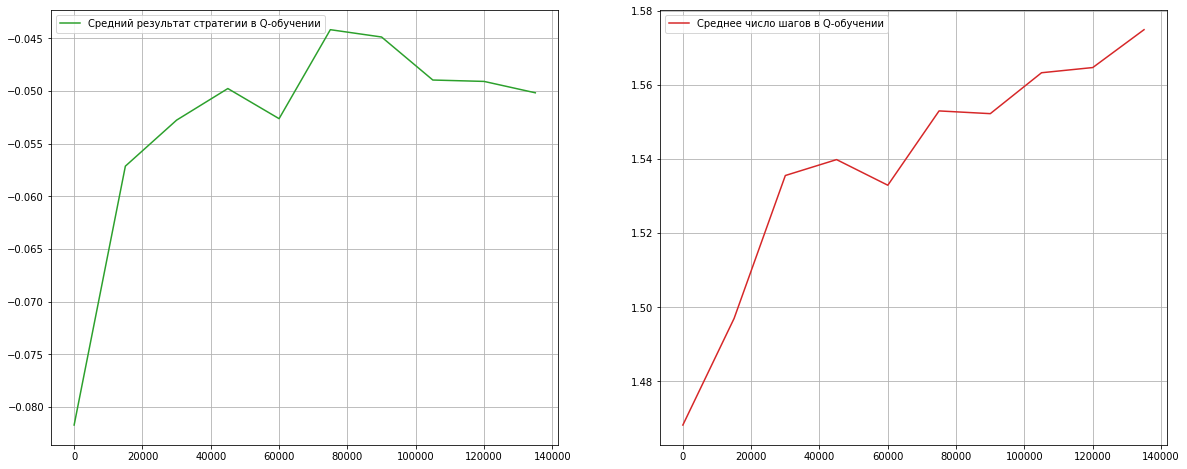

In [204]:
plot_results(results_Qlearn, verbose_rate)

In [205]:
result = np.asarray(result)
rewards, steps = result[:,0], result[:,1]
print(f'Средняя награда: {rewards.mean()}')
print(f'Среднее число шагов: {steps.mean()}')

Средняя награда: -0.050183
Среднее число шагов: 1.5748929999999999


Наилучший выйгрышь опять при gamma = 0.99, равный -0.0426

# Часть третья, в главной роли — Дастин Хоффман

Импортируем изменнёную среду из файла

In [159]:
print(black_jack.state_id)

{-10: 0, -9: 1, -8: 2, -7: 3, -6: 4, -5: 5, -4: 6, -3: 7, -2: 8, -1: 9, 0: 10, 1: 11, 2: 12, 3: 13, 4: 14, 5: 15, 6: 16, 7: 17, 8: 18, 9: 19, 10: 20}


In [158]:
from black_jack import BlackjackEnv

Запишем функции обучение

In [160]:
env = BlackjackEnv(natural=True)
player_hands, dealer_hands, aces, deck_states = env.observation_space[0].n, env.observation_space[1].n, env.observation_space[2].n, env.observation_space[3].n

nS = player_hands * dealer_hands * aces * deck_states * 2 
nA = 3
final_states = [range(22, player_hands)]

def correct(obs):
    return obs[0], obs[1], 1 if obs[2] else 0, obs[3]

def get_random_Q():
    Q = np.random.random(size=(player_hands, dealer_hands, aces, deck_states, 2, nA))
    Q[final_states] = 0.0
    Q[..., 0,:] = 0
    return Q

def Q_learning_episode_with_count(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    obs = correct(env.reset())
    s = obs + (1,)
    a = pi[s] if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(1000):
        obs, reward, done, info = env.step(a)
        obs = correct(obs)
        s_prime = obs + (a % 2,)
        a_prime = pi[s_prime] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max(Q[s_prime]) - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            break
    
    return Q

def conduct_experiments_pi_with_count(env, pi, num_experiments=1000):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        obs = correct(env.reset())
        s = obs + (1,)
        num_steps.append(0)
        total_reward.append(0)
        for _ in range(1000):
            obs, reward, done, info = env.step(pi[s])
            obs = correct(obs)
            s = obs + (pi[s] % 2,)
            total_reward[-1] += reward
            num_steps[-1] += 1
            if done:
                break
    return np.mean(total_reward), np.mean(num_steps)

Протестируем этот код для gamma = [0.3, 0.5, 0.7, 0.8, 0.9 и 0.99]

In [190]:
env = BlackjackEnv(natural=True)
num_experiments, num_experiments_pi = 1, 20000
verbose_rate = 200000

total_episodes = 2000000
gamma = 0.3

results_Qlearn = []


Q_arr = [ get_random_Q() for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]

for n in tqdm(range(1, total_episodes+1)):
    [Q_learning_episode_with_count(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments)]
    pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]
    if n % verbose_rate == 0:
        result = [ conduct_experiments_pi_with_count(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


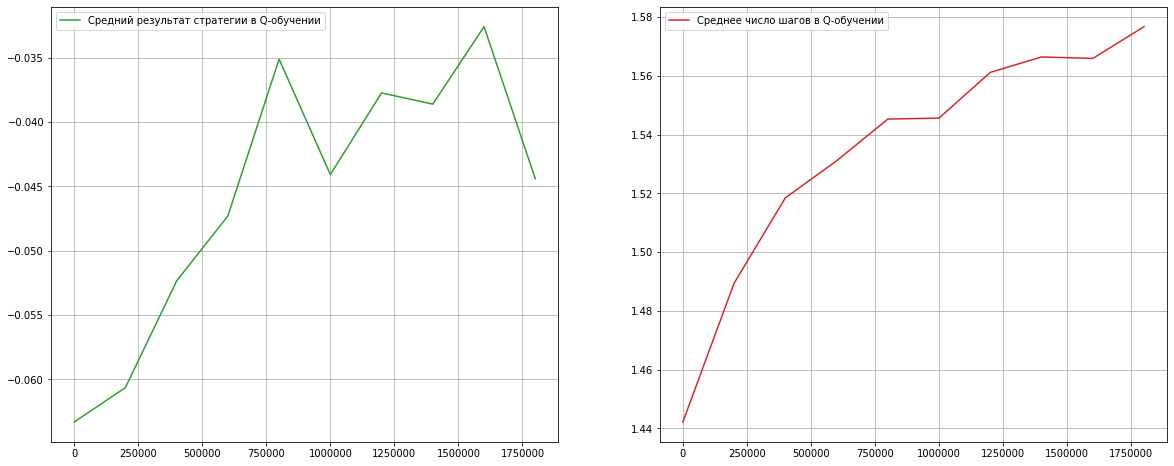

In [191]:
plot_results(results_Qlearn, verbose_rate)

In [192]:
result = np.asarray([ conduct_experiments_pi_with_count(env, pi, num_experiments=200000) for pi in pi_arr ])
rewards, steps = result[:,0], result[:,1]
print(f'Средняя награда: {rewards.mean()}')
print(f'Среднее число шагов: {steps.mean()}')

Средняя награда: -0.042625
Среднее число шагов: 1.570935


In [167]:
env = BlackjackEnv(natural=True)
num_experiments, num_experiments_pi = 1, 20000
verbose_rate = 200000

total_episodes = 2000000
gamma = 0.5

results_Qlearn = []


Q_arr = [ get_random_Q() for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]

for n in tqdm(range(1, total_episodes+1)):
    [Q_learning_episode_with_count(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments)]
    pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]
    if n % verbose_rate == 0:
        result = [ conduct_experiments_pi_with_count(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


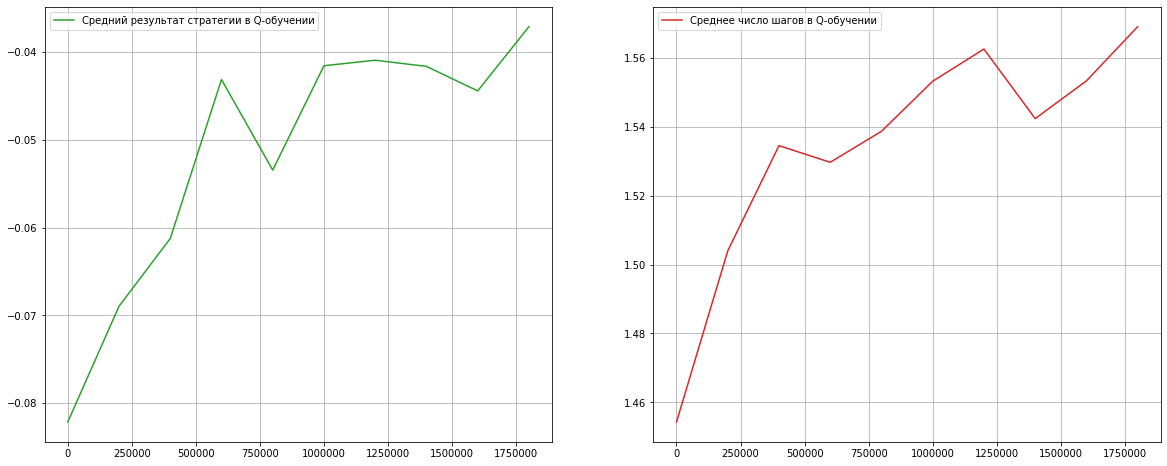

In [168]:
plot_results(results_Qlearn, verbose_rate)

In [222]:
result = np.asarray([ conduct_experiments_pi_with_count(env, pi, num_experiments=200000) for pi in pi_arr ])
rewards, steps = result[:,0], result[:,1]
print(f'Средняя награда: {rewards.mean()}')
print(f'Среднее число шагов: {steps.mean()}')

Средняя награда: -0.03937125
Среднее число шагов: 1.5873775


In [223]:
env = BlackjackEnv(natural=True)
num_experiments, num_experiments_pi = 1, 20000
verbose_rate = 200000

total_episodes = 2000000
gamma = 0.7

results_Qlearn = []


Q_arr = [ get_random_Q() for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]

for n in tqdm(range(1, total_episodes+1)):
    [Q_learning_episode_with_count(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments)]
    pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]
    if n % verbose_rate == 0:
        result = [ conduct_experiments_pi_with_count(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


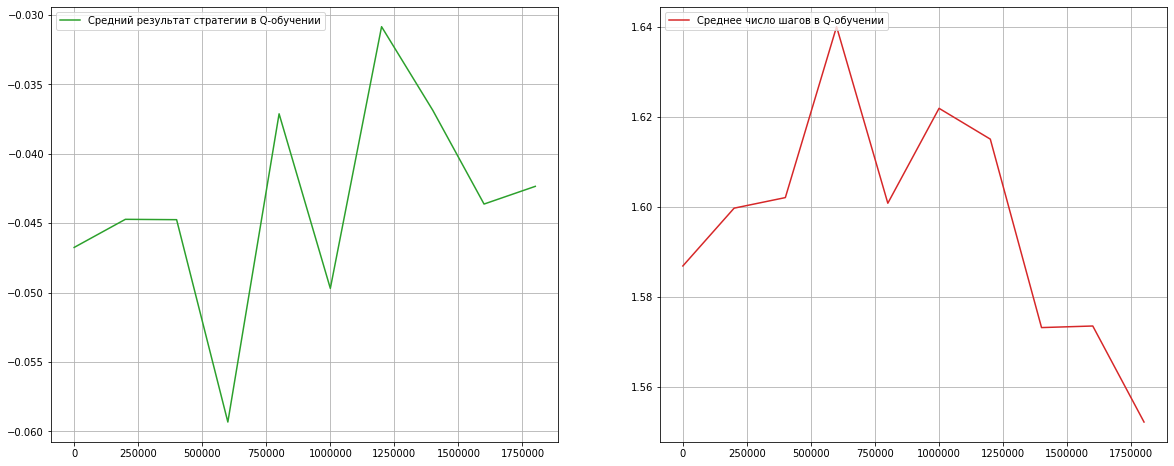

In [224]:
plot_results(results_Qlearn, verbose_rate)

In [225]:
result = np.asarray([ conduct_experiments_pi_with_count(env, pi, num_experiments=200000) for pi in pi_arr ])
rewards, steps = result[:,0], result[:,1]
print(f'Средняя награда: {rewards.mean()}')
print(f'Среднее число шагов: {steps.mean()}')

Средняя награда: -0.03765
Среднее число шагов: 1.55373


In [181]:
env = BlackjackEnv(natural=True)
num_experiments, num_experiments_pi = 1, 20000
verbose_rate = 200000

total_episodes = 2000000
gamma = 0.8

results_Qlearn = []


Q_arr = [ get_random_Q() for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]

for n in tqdm(range(1, total_episodes+1)):
    [Q_learning_episode_with_count(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments)]
    pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]
    if n % verbose_rate == 0:
        result = [ conduct_experiments_pi_with_count(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


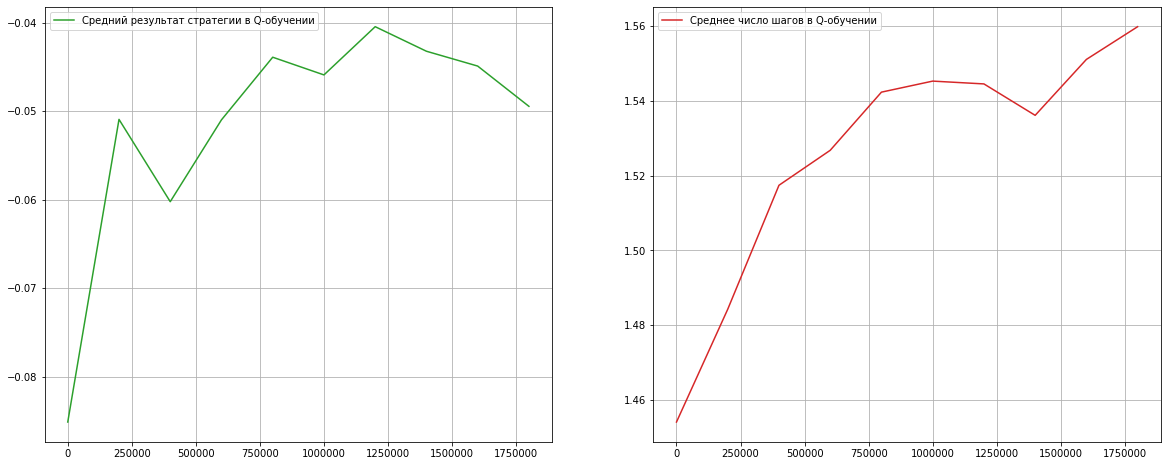

In [182]:
plot_results(results_Qlearn, verbose_rate)

In [183]:
result = np.asarray([ conduct_experiments_pi_with_count(env, pi, num_experiments=200000) for pi in pi_arr ])
rewards, steps = result[:,0], result[:,1]
print(f'Средняя награда: {rewards.mean()}')
print(f'Среднее число шагов: {steps.mean()}')

Средняя награда: -0.04444
Среднее число шагов: 1.562555


In [184]:
env = BlackjackEnv(natural=True)
num_experiments, num_experiments_pi = 1, 20000
verbose_rate = 200000

total_episodes = 2000000
gamma = 0.9

results_Qlearn = []


Q_arr = [ get_random_Q() for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]

for n in tqdm(range(1, total_episodes+1)):
    [Q_learning_episode_with_count(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments)]
    pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]
    if n % verbose_rate == 0:
        result = [ conduct_experiments_pi_with_count(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


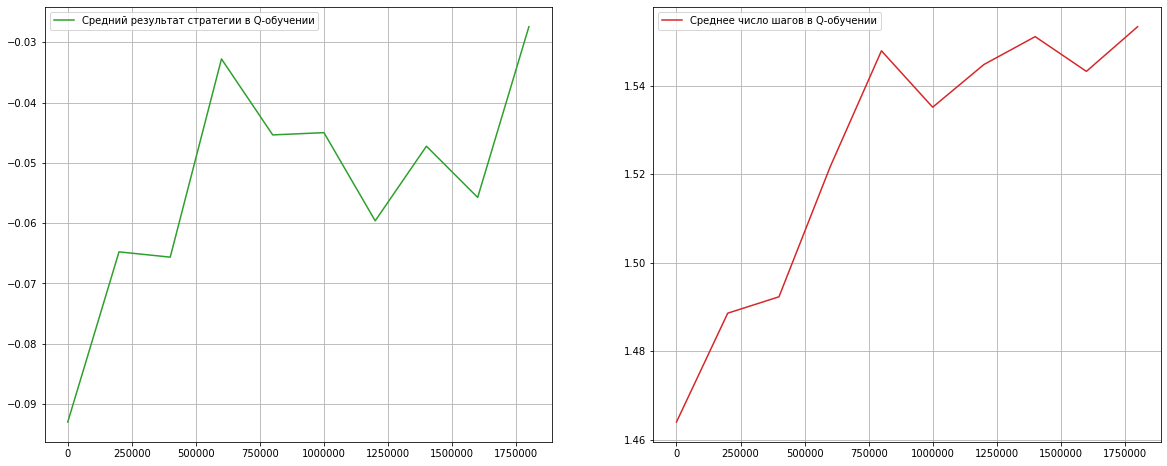

In [185]:
plot_results(results_Qlearn, verbose_rate)

In [186]:
result = np.asarray([ conduct_experiments_pi_with_count(env, pi, num_experiments=200000) for pi in pi_arr ])
rewards, steps = result[:,0], result[:,1]
print(f'Средняя награда: {rewards.mean()}')
print(f'Среднее число шагов: {steps.mean()}')

Средняя награда: -0.04022
Среднее число шагов: 1.55524


In [187]:
env = BlackjackEnv(natural=True)
num_experiments, num_experiments_pi = 1, 20000
verbose_rate = 200000

total_episodes = 2000000
gamma = 0.99

results_Qlearn = []


Q_arr = [ get_random_Q() for _ in range(num_experiments) ]
pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]

for n in tqdm(range(1, total_episodes+1)):
    [Q_learning_episode_with_count(env, pi_arr[i], Q_arr[i], alpha=0.1, epsilon= .1 , gamma=gamma) for i in range(num_experiments)]
    pi_arr = [ compute_policy_by_Q(Q) for Q in Q_arr ]
    if n % verbose_rate == 0:
        result = [ conduct_experiments_pi_with_count(env, pi, num_experiments=num_experiments_pi) for pi in pi_arr ]
        results_Qlearn.append([ [x[0], x[1]] for x in result ])

env.close()

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


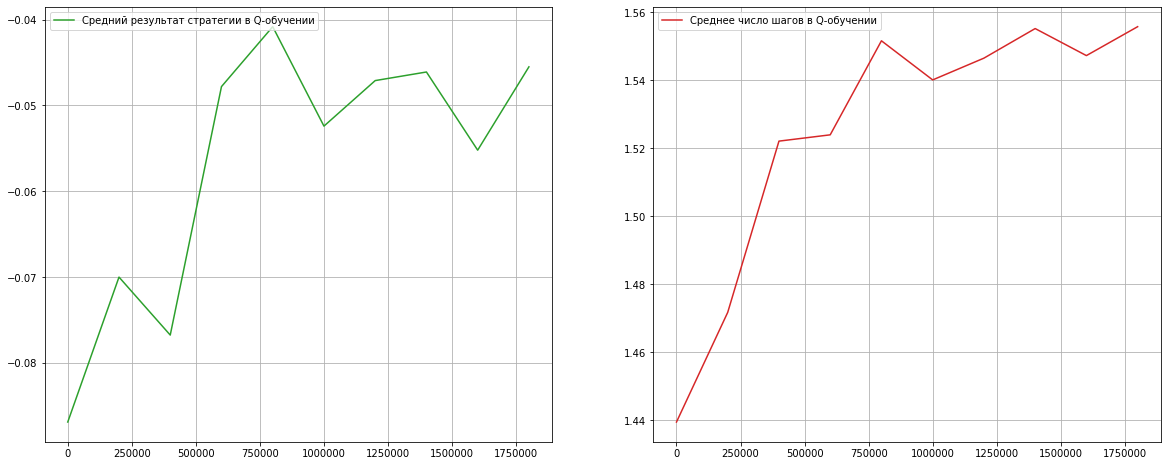

In [188]:
plot_results(results_Qlearn, verbose_rate)

In [189]:
result = np.asarray([ conduct_experiments_pi_with_count(env, pi, num_experiments=200000) for pi in pi_arr ])
rewards, steps = result[:,0], result[:,1]
print(f'Средняя награда: {rewards.mean()}')
print(f'Среднее число шагов: {steps.mean()}')

Средняя награда: -0.0494375
Среднее число шагов: 1.55258


Наилучший результат был достигнуть при gamma = 0.7. Выйгрышь составляет -0.03765.

# Выводы

1) Обыграть казино не удалось

2) В отличие от моделей в 1-ой и 2-ой части задания, модель из 3-ей части лучше всего себя показывает при gamma'х заметно меньших 1 (0.5, 0.7). Скорее всего это связано с тем, что маленькое значение гаммы провоцирует модель чаще играть удвоение, тем самым пользуясь преимуществом в виде подсчета карт, так как с помощью удвоение можно поднимать ставку при наличие "хорошей" колоды. Если же взять гамму, близкую к 1, то модель будет боятся играть удвоение, предпочитая более безопасный hit.